## Imports

In [11]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

## Carregamento e Tratamento de dados

In [12]:
# Carregar os dados
df = pd.read_csv('../database/dados.csv')

# Conversão e ordenação
df['Data'] = pd.to_datetime(df['Data'], infer_datetime_format=True, dayfirst=True)
df = df.sort_values('Data')

# Tratamento das colunas numéricas
df['Vol.'] = df['Vol.'].str.replace('B', '').str.replace('M', '').str.replace(',', '')
df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
df['Vol.'].fillna(method='ffill', inplace=True)

colunas_precos = ['Último', 'Abertura', 'Máxima', 'Mínima']
for coluna in colunas_precos:
    if df[coluna].dtype == 'object':
        df[coluna] = df[coluna].str.replace(',', '').astype(float)
    else:
        df[coluna] = df[coluna].astype(float)

# Verificação de valores ausentes
df.fillna(method='ffill', inplace=True)

# Seleção da coluna de fechamento
fechamento = df[['Data', 'Último']].set_index('Data')

# Separação em treino e teste
treino = fechamento.iloc[:-30]
teste = fechamento.iloc[-30:]


C:\Users\athos\AppData\Local\Temp\ipykernel_2896\4202071299.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Data'] = pd.to_datetime(df['Data'], infer_datetime_format=True, dayfirst=True)
C:\Users\athos\AppData\Local\Temp\ipykernel_2896\4202071299.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['V

## Modelo com Arima

c:\Users\athos\anaconda3\envs\ai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\athos\anaconda3\envs\ai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\athos\anaconda3\envs\ai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA - MSE: 18.02, MAPE: 2.77%, Acurácia: 97.23%


c:\Users\athos\anaconda3\envs\ai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\athos\anaconda3\envs\ai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


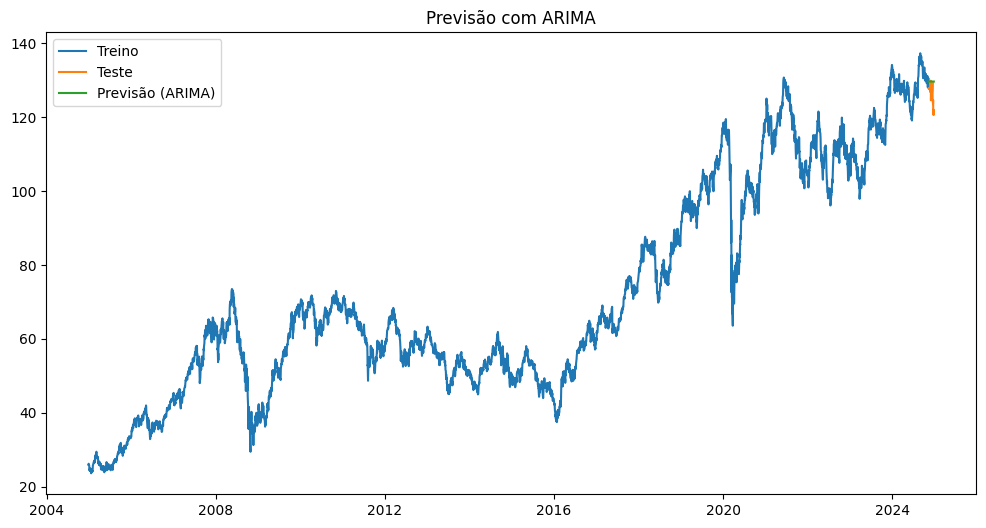

In [13]:
# Treinamento ARIMA
modelo_arima = ARIMA(treino, order=(5, 1, 0))
modelo_arima_treinado = modelo_arima.fit()
previsoes_arima = modelo_arima_treinado.forecast(steps=30)

# Avaliação ARIMA
mse_arima = mean_squared_error(teste, previsoes_arima)
mape_arima = np.mean(np.abs((teste.values - previsoes_arima.values) / teste.values)) * 100
acuracia_arima = 100 - mape_arima

print(f"ARIMA - MSE: {mse_arima:.2f}, MAPE: {mape_arima:.2f}%, Acurácia: {acuracia_arima:.2f}%")

# Gráfico do ARIMA
plt.figure(figsize=(12, 6))
plt.plot(treino.index, treino, label='Treino')
plt.plot(teste.index, teste, label='Teste')
plt.plot(teste.index, previsoes_arima, label='Previsão (ARIMA)')
plt.title('Previsão com ARIMA')
plt.legend()
plt.show()


## Modelo com XGBoost

XGBoost - MSE: 2.68, MAPE: 1.05%, Acurácia: 98.95%


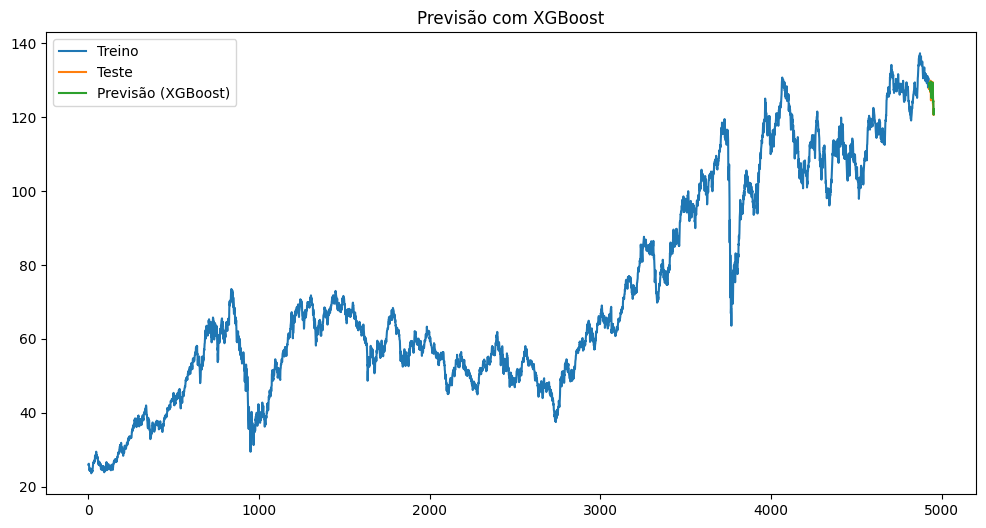

In [14]:
# Função para criar janelas
def criar_janelas(series, janela):
    X, y = [], []
    for i in range(janela, len(series)):
        X.append(series[i-janela:i])
        y.append(series[i])
    return np.array(X), np.array(y)

janela = 30
X_treino, y_treino = criar_janelas(treino['Último'].values, janela)
dados_completos = np.concatenate([treino['Último'].values[-janela:], teste['Último'].values])
X_teste, y_teste = criar_janelas(dados_completos, janela)

# Treinamento XGBoost
modelo_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
modelo_xgb.fit(X_treino, y_treino)
previsoes_xgb = modelo_xgb.predict(X_teste)

# Avaliação XGBoost
mse_xgb = mean_squared_error(y_teste, previsoes_xgb)
mape_xgb = np.mean(np.abs((y_teste - previsoes_xgb) / y_teste)) * 100
acuracia_xgb = 100 - mape_xgb

print(f"XGBoost - MSE: {mse_xgb:.2f}, MAPE: {mape_xgb:.2f}%, Acurácia: {acuracia_xgb:.2f}%")

# Gráfico do XGBoost
plt.figure(figsize=(12, 6))
plt.plot(range(len(treino)), treino, label='Treino')
plt.plot(range(len(treino), len(treino) + len(teste)), teste, label='Teste')
plt.plot(range(len(treino), len(treino) + len(teste)), previsoes_xgb, label='Previsão (XGBoost)')
plt.title('Previsão com XGBoost')
plt.legend()
plt.show()


## Gráficos comparativos entre os modelos

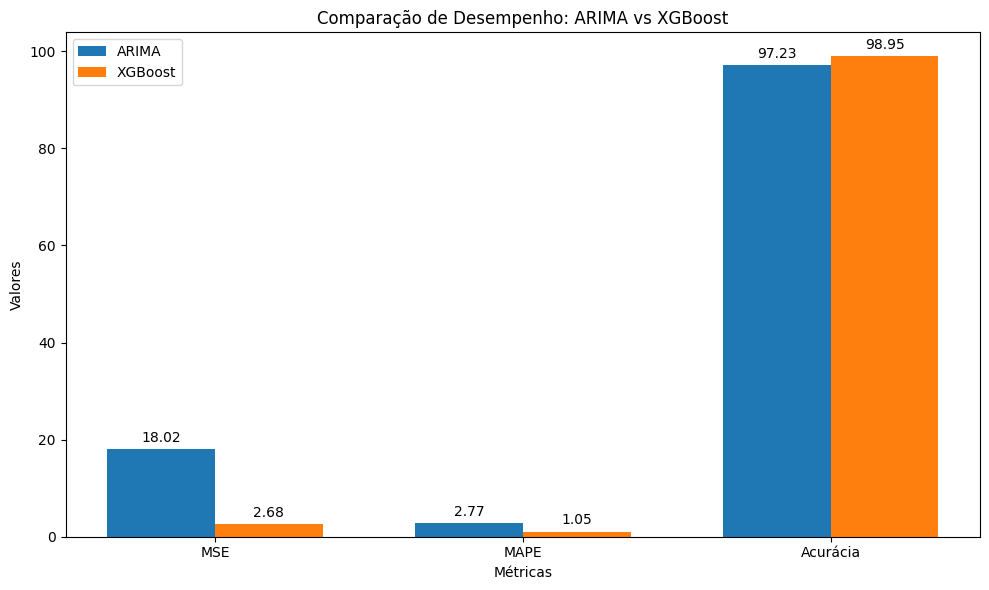

In [15]:
# Comparação Gráfica de Desempenho
metricas = ['MSE', 'MAPE', 'Acurácia']
arima_valores = [mse_arima, mape_arima, acuracia_arima]
xgboost_valores = [mse_xgb, mape_xgb, acuracia_xgb]

x = np.arange(len(metricas))
largura = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
barras_arima = ax.bar(x - largura / 2, arima_valores, largura, label='ARIMA')
barras_xgboost = ax.bar(x + largura / 2, xgboost_valores, largura, label='XGBoost')

ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparação de Desempenho: ARIMA vs XGBoost')
ax.set_xticks(x)
ax.set_xticklabels(metricas)
ax.legend()

def adicionar_valores(barras):
    for barra in barras:
        altura = barra.get_height()
        ax.annotate(f'{altura:.2f}',
                    xy=(barra.get_x() + barra.get_width() / 2, altura),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

adicionar_valores(barras_arima)
adicionar_valores(barras_xgboost)

plt.tight_layout()
plt.show()
